In [ ]:
%tensorflow_version 1.x

In [ ]:
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer


In [ ]:
def prepro_data():
  ###### Load Data and Features Selection ########
  dataset = pd.read_csv("E202-COMP7117-TD01-00 - classification.csv")

  features = dataset[[ 
  "volatile acidity",  
  "chlorides", 
  "free sulfur dioxide", 
  "total sulfur dioxide", 
  "density",
  "pH",
  "sulphates",
  "alcohol"]]  

  target = dataset[["quality"]]
  
  ###### Encoding ########
  sz = len(features)
  tmp = []

  for i in range(sz):
    if (features["free sulfur dioxide"].loc[i] == 'High'):
      tmp.append(3)
    elif (features["free sulfur dioxide"].loc[i] == 'Medium'):
      tmp.append(2)
    elif (features["free sulfur dioxide"].loc[i] == 'Low'):
      tmp.append(1)
    else:
      tmp.append(0)
  features.drop(columns=["free sulfur dioxide"])
  features["free sulfur dioxide"] = tmp

  tmp = []

  for i in range(sz):
    if (features["density"].loc[i] == 'High'):
      tmp.append(3)
    elif (features["density"].loc[i] == 'Medium'):
      tmp.append(2)
    elif (features["density"].loc[i] == 'Low'):
      tmp.append(1)
    elif (features["density"].loc[i] == 'Very High'):
      tmp.append(0)
  features.drop(columns=["density"])
  features["density"] = tmp

  tmp = []

  for i in range(sz):
    if (features["pH"].loc[i] == 'Very Basic'):
      tmp.append(3)
    elif (features["pH"].loc[i] == 'Normal'):
      tmp.append(2)
    elif (features["pH"].loc[i] == 'Very Acidic'):
      tmp.append(1)
    else:
      tmp.append(0)
  features.drop(columns=["pH"])
  features["pH"] = tmp

  ###### Normalization ########
  normalizer = PowerTransformer(method='box-cox', standardize=False)
  normal_data = normalizer.fit_transform(features-features.min()+1)


  ######## PCA ########
  pca = PCA(n_components=4)
  pca = pca.fit(normal_data)

  data = pca.transform(normal_data)

  encoder = OneHotEncoder(sparse=False)
  target = encoder.fit_transform(target)

  return data, target


In [ ]:
################# Architecture #################
layers = {
    "Input" : 4,
    "Hidden" : 15,
    "Output" : 5
}


In [ ]:
################# Initialization #################
input_dataset, output_dataset = prepro_data()

weight = {
    "input_to_hidden" : tf.Variable(tf.random_normal([layers["Input"], layers["Hidden"]])),
    "hidden_to_output" : tf.Variable(tf.random_normal([layers["Hidden"], layers["Output"]]))
}

biases = {
    "input_to_hidden" : tf.Variable(tf.random_normal([layers["Hidden"]])),
    "hidden_to_output" : tf.Variable(tf.random_normal([layers["Output"]]))
}

input_placeholder = tf.placeholder(tf.float32, [None, layers["Input"]])
target_placeholder = tf.placeholder(tf.float32, [None, layers["Output"]])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

# Trainin and Tesing

In [ ]:
################## Split Dataset ####################
input_train, input_test, output_train, output_test = train_test_split(input_dataset, output_dataset, test_size=0.3, random_state=4)  # 0.7 train, 0.3 test
input_test, input_val, output_test, output_val = train_test_split(input_test, output_test, test_size = 0.67, random_state=1)  # 1/3 test, 2/3 val


In [ ]:
################## Training ####################
def feed_forward(datas):
    input_to_hidden_bias = tf.matmul(datas, weight["input_to_hidden"]) + biases["input_to_hidden"]

    activated_input_to_hidden = tf.nn.sigmoid(input_to_hidden_bias)

    hidden_to_output_bias = tf.matmul(activated_input_to_hidden, weight["hidden_to_output"]) + biases["hidden_to_output"]
    activated_hidden_to_output = tf.nn.sigmoid(hidden_to_output_bias)

    return activated_hidden_to_output

output = feed_forward(input_placeholder)


epoch = 5000
alpha = 0.5

errors = tf.reduce_mean( 0.5 * (target_placeholder - output) ** 2 ) # 1. MSE

optimizer = tf.train.GradientDescentOptimizer(alpha) # 2. 
train = optimizer.minimize(errors)

matches = tf.equal(tf.argmax(target_placeholder, axis = 1), tf.argmax(output, axis = 1))
accuracy = tf.reduce_mean(tf.cast(matches, tf.float32))

saver = tf.train.Saver()

loss_history = []
minimum_error = 1000000000

with tf.Session() as sess:  
    sess.run(tf.global_variables_initializer())

    for i in range(1, epoch+1):
        train_dict = {
            input_placeholder : input_train,
            target_placeholder : output_train
        }

        sess.run(train, feed_dict=train_dict)
        loss = sess.run(errors, feed_dict=train_dict)

        if(i % 100 == 0): 
            print("Current error: {}, Epoch number: {}".format(loss, i))

        if(i % 500 == 0):
          val_dict = {
              input_placeholder : input_val,
              target_placeholder : output_val
          }
          # sess.run(train, feed_dict=val_dict)
          loss = sess.run(errors, feed_dict=val_dict)
          loss_history.append(loss)

          print("Accuracy: {}%".format(sess.run(accuracy, feed_dict=val_dict) * 100))
          if(loss < minimum_error):
            minimum_error = loss
            loss_history.append(loss)
            saver.save(sess, "my-model/model.ckpt") #save model
          else:
            print("BAD")

 

    test_dict = {
        input_placeholder : input_test,
        target_placeholder : output_test
    }

    print("Accuracy: {}%".format(sess.run(accuracy, feed_dict=test_dict) * 100))
            

Current error: 0.1457556039094925, Epoch number: 100
Current error: 0.09083929657936096, Epoch number: 200
Current error: 0.083224818110466, Epoch number: 300
Current error: 0.07657535374164581, Epoch number: 400
Current error: 0.06999406963586807, Epoch number: 500
Accuracy: 41.61490797996521%
Current error: 0.0666651800274849, Epoch number: 600
Current error: 0.065141461789608, Epoch number: 700
Current error: 0.0642874613404274, Epoch number: 800
Current error: 0.06377502530813217, Epoch number: 900
Current error: 0.06343697011470795, Epoch number: 1000
Accuracy: 50.621116161346436%
Current error: 0.06318406015634537, Epoch number: 1100
Current error: 0.06297054886817932, Epoch number: 1200
Current error: 0.062773697078228, Epoch number: 1300
Current error: 0.06258386373519897, Epoch number: 1400
Current error: 0.06239974871277809, Epoch number: 1500
Accuracy: 51.552796363830566%
Current error: 0.06222585588693619, Epoch number: 1600
Current error: 0.062068402767181396, Epoch number

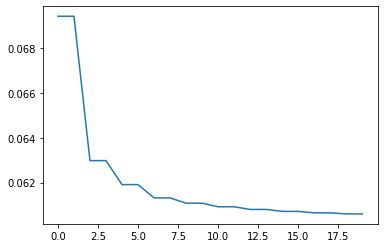

In [ ]:
plt.plot(loss_history)
plt.show()


In [ ]:
# ################## Testing ####################
with tf.Session() as sess:
    saver.restore(sess, "my-model/model.ckpt")

    matches = tf.equal(tf.argmax(target_placeholder, axis = 1), tf.argmax(output, axis = 1))

    accuracy = tf.reduce_mean(tf.cast(matches, tf.float32))

    test_dict = {
        input_placeholder : input_test,
        target_placeholder : output_test
    }

    print("Accuracy: {}%".format(sess.run(accuracy, feed_dict=test_dict) * 100))

INFO:tensorflow:Restoring parameters from my-model/model.ckpt
Accuracy: 53.797465562820435%
